In [31]:
import pandas as pd

# save the patients_df
df = pd.read_csv('./data/msk_2024_fe_15.csv')
os_months_index = df.columns.get_loc("OS_MONTHS")

gene_mutations = df.iloc[:, 1:os_months_index]  # Exclude the first column (ID) and OS_MONTHS
data_labels = df.iloc[:, os_months_index:]  # Include only the OS_MONTHS column as labels

In [32]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from lifelines.utils import concordance_index
from sklearn.preprocessing import StandardScaler

# -------------------------------------------------------------

# Extract patient IDs
patient_ids = df['Patient'].values

# Get binary mutation features; convert to float32 for PyTorch
GMP = gene_mutations

CD_BINARY = data_labels[['highest_stage_recorded', 'CNS_BRAIN', 'LIVER', 'LUNG', 'Regional', 'Distant', 'CANCER_TYPE_BREAST', 'CANCER_TYPE_COLON', 'CANCER_TYPE_LUNG', 'CANCER_TYPE_PANCREAS', 'CANCER_TYPE_PROSTATE']]
CD_NUMERIC = data_labels[['CURRENT_AGE_DEID', 'TMB_NONSYNONYMOUS', 'FRACTION_GENOME_ALTERED']]

# Get the column names for each modality.
gmp_columns = gene_mutations.columns.tolist()
cd_columns = CD_BINARY.columns.tolist() + CD_NUMERIC.columns.tolist()
all_columns = gmp_columns + cd_columns  # final feature order in X

GMP = GMP.values.astype(np.float32)
CD_BINARY = CD_BINARY.values.astype(np.float32)
CD_NUMERIC = CD_NUMERIC.values.astype(np.float32)

# --- Process CURRENT_AGE_DEID (left-skewed) ---
# Reflect the age values: higher ages become lower values.
max_age = np.max(CD_NUMERIC[:, 0])
age_reflected = max_age - CD_NUMERIC[:, 0]

# Apply log transformation to the reflected age.
age_log = np.log1p(age_reflected)  # log1p ensures numerical stability for zero values.

# Standardize the transformed age.
scaler_age = StandardScaler()
age_normalized = scaler_age.fit_transform(age_log.reshape(-1, 1))

# --- Process TMB_NONSYNONYMOUS and FRACTION_GENOME_ALTERED (right-skewed) ---
# Apply log1p transformation to both features.
tmb_log = np.log1p(CD_NUMERIC[:, 1])
frac_log = np.log1p(CD_NUMERIC[:, 2])

# Standardize the transformed features.
scaler_tmb = StandardScaler()
tmb_normalized = scaler_tmb.fit_transform(tmb_log.reshape(-1, 1))

scaler_frac = StandardScaler()
frac_normalized = scaler_frac.fit_transform(frac_log.reshape(-1, 1))

# --- Combine normalized features ---
# The resulting cd_numeric_normalized will have the same shape as the original.
CD_NUMERIC = np.hstack([age_normalized, tmb_normalized, frac_normalized])
CD = np.hstack([CD_BINARY, CD_NUMERIC])
X = np.hstack([GMP, CD])  # Combine gene mutations and clinical data

y_os = data_labels["OS_MONTHS"].values  # Overall survival time
y_status = data_labels["OS_STATUS"].values  # Overall survival status (0 = alive (censored), 1 = dead (event))

# Train-Validation-Test Split
X_train, X_temp, y_os_train, y_os_temp, y_status_train, y_status_temp = train_test_split(
    X, y_os, y_status, test_size=0.3
)
X_val, X_test, y_os_val, y_os_test, y_status_val, y_status_test = train_test_split(
    X_temp, y_os_temp, y_status_temp, test_size=0.5
)

# Convert to PyTorch tensors
X_train, y_os_train, y_status_train = map(torch.tensor, (X_train, y_os_train, y_status_train))
X_val, y_os_val, y_status_val = map(torch.tensor, (X_val, y_os_val, y_status_val))
X_test, y_os_test, y_status_test = map(torch.tensor, (X_test, y_os_test, y_status_test))

# Move to float tensors
X_train, X_val, X_test = X_train.float(), X_val.float(), X_test.float()
y_os_train, y_os_val, y_os_test = y_os_train.float(), y_os_val.float(), y_os_test.float()
y_status_train, y_status_val, y_status_test = y_status_train.float(), y_status_val.float(), y_status_test.float()

print(f"Train Size: {X_train.shape}, Validation Size: {X_val.shape}, Test Size: {X_test.shape}")


Train Size: torch.Size([15598, 980]), Validation Size: torch.Size([3343, 980]), Test Size: torch.Size([3343, 980])


In [33]:
class CancerTransformer(nn.Module):
    def __init__(self, num_genes, embed_dim=256, num_heads=8, ff_dim=256, num_layers=2, dropout=0.2):
        super(CancerTransformer, self).__init__()

        # Embedding layer: maps binary mutation profile (0,1) to continuous embedding.
        self.embedding = nn.Linear(num_genes, embed_dim)

        # Transformer Encoder with batch_first=True so input shape is (batch, seq, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, 
                                                   nhead=num_heads, 
                                                   dim_feedforward=ff_dim, 
                                                   dropout=dropout,
                                                   batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Risk score head.
        self.fc = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 1)  # risk score output
        )

    def forward(self, x):
        # x: [batch, num_genes]
        x = self.embedding(x)         # [batch, embed_dim]
        x = x.unsqueeze(1)            # [batch, 1, embed_dim] => sequence length is 1.
        x = self.transformer_encoder(x)  # [batch, 1, embed_dim]
        x = x.mean(dim=1)            # Pool over sequence dimension => [batch, embed_dim]
        x = self.fc(x)               # [batch, 1]
        return x
    
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim1 = 256, hidden_dim2 = 256, dropout=0.3):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.bn1 = nn.BatchNorm1d(hidden_dim1)
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.bn2 = nn.BatchNorm1d(hidden_dim2)
        self.dropout2 = nn.Dropout(dropout)
        self.fc3 = nn.Linear(hidden_dim2, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [34]:
# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X_train, y_os_train, y_status_train = X_train.to(device), y_os_train.to(device), y_status_train.to(device)
X_val, y_os_val, y_status_val = X_val.to(device), y_os_val.to(device), y_status_val.to(device)
X_test, y_os_test, y_status_test = X_test.to(device), y_os_test.to(device), y_status_test.to(device)

# normalize the y_os_train, y_os_val, y_os_test using log1p
y_os_train = torch.log1p(y_os_train)
y_os_val = torch.log1p(y_os_val)
y_os_test = torch.log1p(y_os_test)

Using device: cpu


In [35]:
def cox_partial_likelihood_loss(risk_scores, times, events):
    """
    Computes the Cox Partial Likelihood loss for survival analysis.

    Parameters:
    - risk_scores: Tensor of predicted risk scores (higher = higher risk).
    - times: Tensor of survival times.
    - events: Tensor indicating event occurrence (1 = event, 0 = censored).

    Returns:
    - Negative log Cox partial likelihood loss.
    """
    # Sort survival times in descending order
    sorted_indices = torch.argsort(times, descending=True)
    sorted_risk = risk_scores[sorted_indices]
    sorted_events = events[sorted_indices]

    # Compute log-cumulative sum of exp(risk) -> LogSumExp trick for numerical stability
    risk_cumsum = torch.logcumsumexp(sorted_risk, dim=0)

    # Select only events (uncensored cases)
    event_mask = sorted_events == 1
    loss = -torch.sum(sorted_risk[event_mask] - risk_cumsum[event_mask])

    return loss / (event_mask.sum() + 1e-8)  # Normalize by number of events

In [36]:
from torch.utils.data import Dataset, DataLoader

# Custom Dataset for Survival Data
class SurvivalDataset(Dataset):
    def __init__(self, X, time, event):
        self.X = X
        self.time = time
        self.event = event
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.time[idx], self.event[idx]

batch_size = 3000  # Adjust based on your memory constraints

# Create dataset objects
train_dataset = SurvivalDataset(X_train, y_os_train, y_status_train)
val_dataset   = SurvivalDataset(X_val, y_os_val, y_status_val)
test_dataset  = SurvivalDataset(X_test, y_os_test, y_status_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# For validation and test we use full batches (since they are smaller)
val_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [55]:
# model = CancerTransformer(num_genes=X_train.shape[1]).to(device)
model = MLP(input_dim=X_train.shape[1], hidden_dim1=128, hidden_dim2=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_epochs = 100

# Example usage:

# To test:
x = torch.randn(8, X_train.shape[1])  # Dummy batch of 8 samples.
output = model(x)
print("Output shape:", output.shape)  # Should be [8, 1]

Output shape: torch.Size([8, 1])


In [56]:
from lifelines.utils import concordance_index

num_epochs = 100
l2_lambda = 1e-4

train_losses, val_losses, val_c_indices = [], [], []

best_model = None
best_val_loss = float('inf')
best_c_index = 0.0

for epoch in range(num_epochs):
    # ---- Training Phase ----
    epoch_loss = 0.0
    model.train()

    for batch_X, batch_time, batch_event in train_loader:
        batch_X, batch_time, batch_event = batch_X.to(device), batch_time.to(device), batch_event.to(device)
        optimizer.zero_grad()
        risk = model(batch_X)
        # loss = hybrid_survival_loss(risk, batch_time, batch_event, alpha=0.5, margin=0.0)
        loss = cox_partial_likelihood_loss(risk, batch_time, batch_event)
        
        l2_reg = 0.0
        for param in model.parameters():
            l2_reg += torch.norm(param,2) ** 2
        loss += l2_reg * l2_lambda
        
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_X.size(0)
    epoch_loss /= len(train_dataset)
        
    # optimizer.zero_grad()
    # risk = model(X_train)
    # loss = cox_partial_likelihood_loss(risk, y_os_train, y_status_train)
    # # loss = smooth_concordance_loss(risk, y_os_train, y_status_train)
    # l2_reg = 0.0
    # for param in model.parameters():
    #     l2_reg += torch.norm(param,2) ** 2
    # loss += l2_reg * l2_lambda
    # loss.backward()
    # optimizer.step()
    # epoch_loss = loss.item()

    train_losses.append(epoch_loss)
    
    # ---- Validation Phase ----
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        # We compute validation loss and predictions on the full validation set
        for val_X, val_time, val_event in val_loader:
            val_X, val_time, val_event = val_X.to(device), val_time.to(device), val_event.to(device)
            val_risk = model(val_X)
            loss = cox_partial_likelihood_loss(val_risk, val_time, val_event)
            # loss = smooth_concordance_loss(val_risk, val_time, val_event)
            
            l2_reg = 0.0
            for param in model.parameters():
                l2_reg += torch.norm(param,2) ** 2
            val_loss = loss + l2_reg * l2_lambda
                        
            # Convert log-transformed times back to original scale for c-index
            val_risk_np = val_risk.cpu().numpy()
            val_time_np = val_time.cpu().numpy()
            val_event_np = val_event.cpu().numpy()
            val_time_orig = np.expm1(val_time_np)
            c_index = concordance_index(val_time_orig, -val_risk_np, val_event_np)
    
    val_losses.append(val_loss.item())
    val_c_indices.append(c_index)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}: Train Loss {epoch_loss:.4f}, Val Loss {val_loss.item():.4f}, "
            f"c-index {c_index:.4f}")
        
    if val_loss < best_val_loss and c_index > best_c_index:
        best_val_loss = val_loss.item()
        best_c_index = c_index
        best_model = model.state_dict()
        print(f"New best model found at epoch {epoch+1} with val_loss: {best_val_loss:.4f} and c-index: {best_c_index:.4f}")

New best model found at epoch 1 with val_loss: 7.5365 and c-index: 0.5610
New best model found at epoch 2 with val_loss: 7.5318 and c-index: 0.6054
New best model found at epoch 3 with val_loss: 7.5228 and c-index: 0.6397
New best model found at epoch 4 with val_loss: 7.5080 and c-index: 0.6636
New best model found at epoch 5 with val_loss: 7.4852 and c-index: 0.6795
New best model found at epoch 6 with val_loss: 7.4540 and c-index: 0.6897
New best model found at epoch 7 with val_loss: 7.4155 and c-index: 0.6963
New best model found at epoch 8 with val_loss: 7.3735 and c-index: 0.7011
New best model found at epoch 9 with val_loss: 7.3322 and c-index: 0.7050
Epoch 10/100: Train Loss 7.1439, Val Loss 7.2964, c-index 0.7082
New best model found at epoch 10 with val_loss: 7.2964 and c-index: 0.7082
New best model found at epoch 11 with val_loss: 7.2702 and c-index: 0.7109
New best model found at epoch 12 with val_loss: 7.2536 and c-index: 0.7130
New best model found at epoch 13 with val_lo

In [57]:
# test the model on the test set
model.load_state_dict(best_model) if best_model is not None else None
model.eval()  # Set to evaluation mode

with torch.no_grad():
    for test_X, test_time, test_event in test_loader:
        test_X, test_time, test_event = test_X.to(device), test_time.to(device), test_event.to(device)
        test_risk = model(test_X)
        # Compute loss on the test set
        
        test_risk_np = test_risk.cpu().numpy()
        test_time_np = test_time.cpu().numpy()
        test_event_np = test_event.cpu().numpy()
        test_time_orig = np.expm1(test_time_np)
        c_index_whole = concordance_index(test_time_orig, -test_risk_np, test_event_np)

        print(f"Test c-index: {c_index_whole:.4f}")

# Save the model
# torch.save(model.state_dict(), f'../models/checkpoints/survival_model_subtype_mlp.pth')

Test c-index: 0.7328


In [58]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from captum.attr import IntegratedGradients

sample_input = X_test[0:1]  # shape: [1, num_genes]
sample_input = sample_input.to(device)
baseline = torch.zeros_like(sample_input)

# Instantiate the IntegratedGradients object with your model.
ig = IntegratedGradients(model)

# Compute attributions.
# For regression outputs, 'target' can be set to 0 (since risk score is a single output).
attributions, delta = ig.attribute(sample_input,
                                   baseline,
                                   target=0,
                                   return_convergence_delta=True)

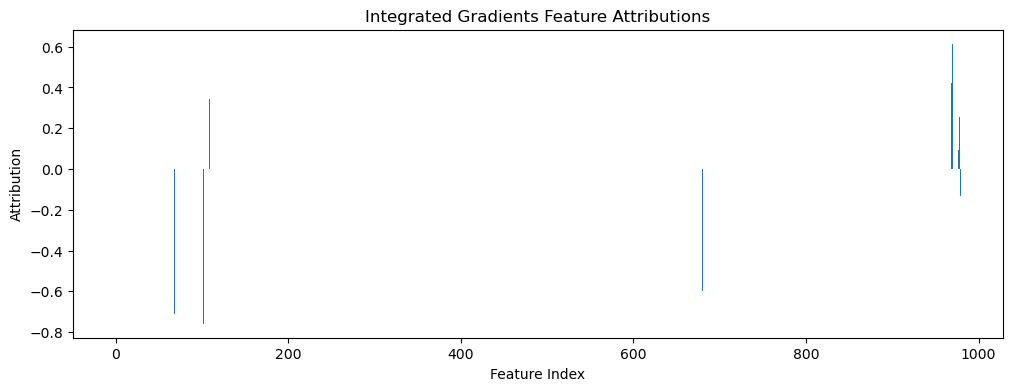

Convergence Delta: 0.0033144490559751105


In [59]:

# Move attributions to CPU and convert to numpy.
attr_np = attributions.cpu().detach().numpy()[0]

# Optionally, you can normalize the attributions.
attr_norm = (attr_np - attr_np.min()) / (attr_np.max() - attr_np.min() + 1e-10)

# Plot the feature attributions.
plt.figure(figsize=(12, 4))
plt.bar(np.arange(len(attr_np)), attr_np)
plt.xlabel("Feature Index")
plt.ylabel("Attribution")
plt.title("Integrated Gradients Feature Attributions")
plt.show()

# Print convergence delta (a measure of approximation quality)
print("Convergence Delta:", delta.item())

Top 20 Features by Integrated Gradients:
SF3B1_Missense_Mutation_SNP_chr2: Attribution = -0.7589, Absolute = 0.7589
ARID2_Missense_Mutation_SNP_chr12: Attribution = -0.7134, Absolute = 0.7134
Regional: Attribution = 0.6146, Absolute = 0.6146
STAT5B_Missense_Mutation_SNP_chr17: Attribution = -0.5992, Absolute = 0.5992
LUNG: Attribution = 0.4210, Absolute = 0.4210
ATRX_Missense_Mutation_SNP_chr23: Attribution = -0.3753, Absolute = 0.3753
ATM_Missense_Mutation_SNP_chr11: Attribution = 0.3414, Absolute = 0.3414
AR_Missense_Mutation_SNP_chr23: Attribution = 0.3048, Absolute = 0.3048
KMT2D_Missense_Mutation_SNP_chr12: Attribution = 0.2536, Absolute = 0.2536
TMB_NONSYNONYMOUS: Attribution = 0.2529, Absolute = 0.2529
FAT1_Missense_Mutation_SNP_chr4: Attribution = 0.2189, Absolute = 0.2189
KRAS_Missense_Mutation_SNP_chr12: Attribution = 0.1860, Absolute = 0.1860
FRACTION_GENOME_ALTERED: Attribution = -0.1344, Absolute = 0.1344
CURRENT_AGE_DEID: Attribution = 0.0941, Absolute = 0.0941
CANCER_TYP

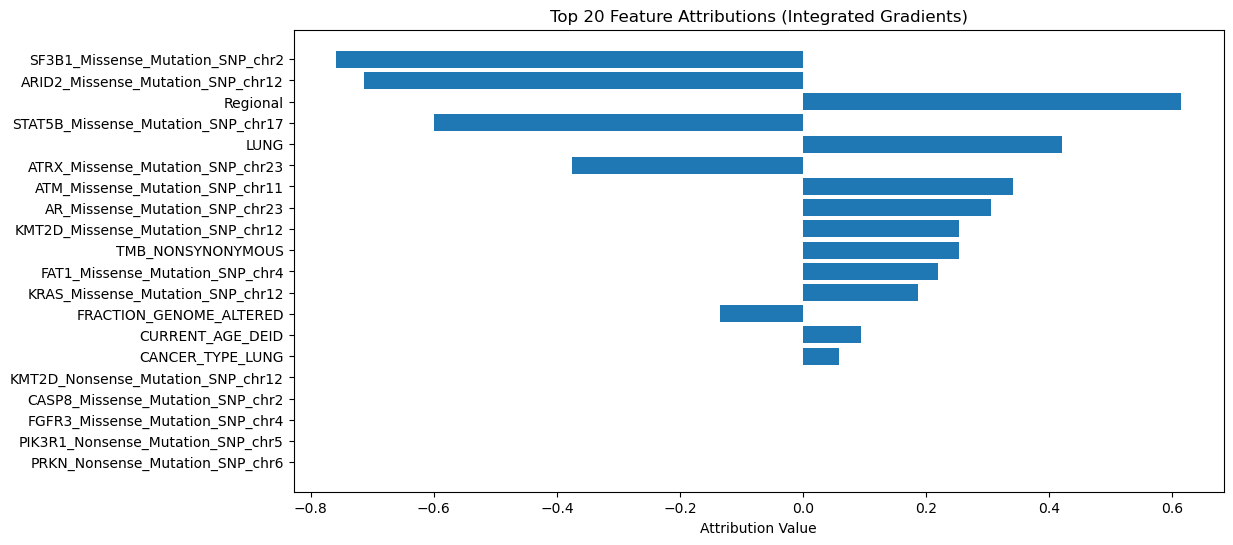

Convergence Delta: 0.0033144490559751105


In [60]:
# Get the column names for each modality.
all_columns
# Compute absolute values and get indices of the top 20 features.
abs_attr = np.abs(attr_np)
top_indices = np.argsort(abs_attr)[::-1][:20]

# Print the top 20 features along with their attributions.
print("Top 20 Features by Integrated Gradients:")
for idx in top_indices:
    print(f"{all_columns[idx]}: Attribution = {attr_np[idx]:.4f}, Absolute = {abs_attr[idx]:.4f}")

# Optionally, plot the attributions of the top features.
top_feature_names = [all_columns[idx] for idx in top_indices]
top_attr_values = attr_np[top_indices]

plt.figure(figsize=(12, 6))
plt.barh(top_feature_names[::-1], top_attr_values[::-1])
plt.xlabel("Attribution Value")
plt.title("Top 20 Feature Attributions (Integrated Gradients)")
plt.show()

print("Convergence Delta:", delta.item())



Top 20 global features by average absolute attribution:
Distant: Mean Abs Attribution = 0.5109
LIVER: Mean Abs Attribution = 0.3818
TMB_NONSYNONYMOUS: Mean Abs Attribution = 0.3371
CNS_BRAIN: Mean Abs Attribution = 0.2422
FRACTION_GENOME_ALTERED: Mean Abs Attribution = 0.2233
LUNG: Mean Abs Attribution = 0.1990
Regional: Mean Abs Attribution = 0.1981
CANCER_TYPE_BREAST: Mean Abs Attribution = 0.1674
CURRENT_AGE_DEID: Mean Abs Attribution = 0.1608
CANCER_TYPE_COLON: Mean Abs Attribution = 0.0963
TP53_Missense_Mutation_SNP_chr17: Mean Abs Attribution = 0.0902
CANCER_TYPE_LUNG: Mean Abs Attribution = 0.0871
KRAS_Missense_Mutation_SNP_chr12: Mean Abs Attribution = 0.0851
highest_stage_recorded: Mean Abs Attribution = 0.0817
CANCER_TYPE_PANCREAS: Mean Abs Attribution = 0.0734
APC_Nonsense_Mutation_SNP_chr5: Mean Abs Attribution = 0.0666
CANCER_TYPE_PROSTATE: Mean Abs Attribution = 0.0358
EGFR_In_Frame_Del_DEL_chr7: Mean Abs Attribution = 0.0344
TP53_Frame_Shift_Del_DEL_chr17: Mean Abs Attr

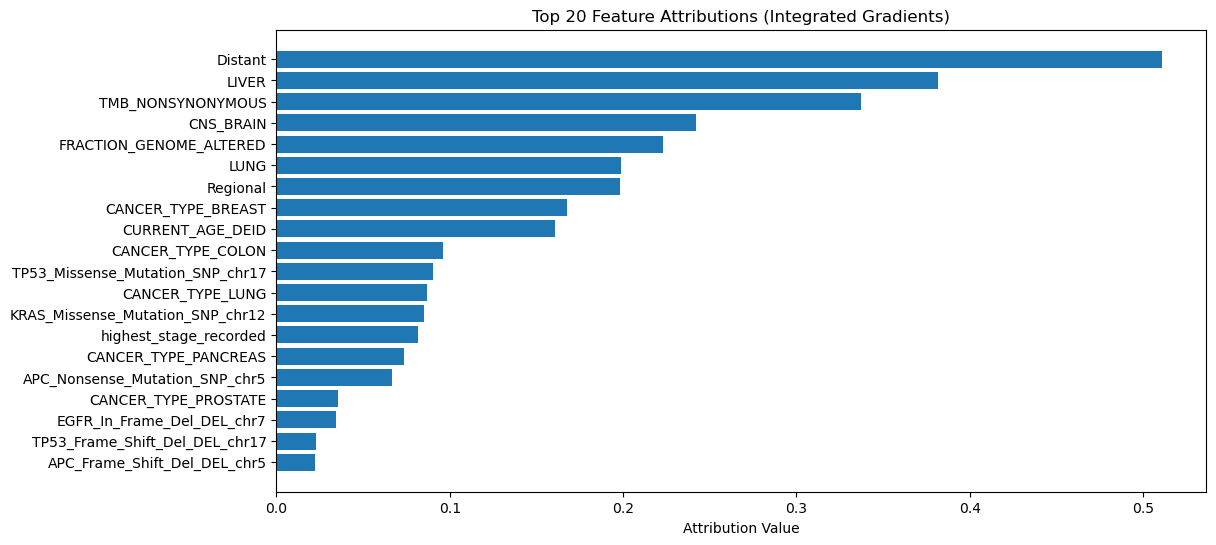

Convergence Delta: 0.0033144490559751105


In [61]:
num_samples = len(X_test)
all_attrs = []
for i in range(num_samples):
    sample = X_test[i:i+1].to(device)
    attr, _ = ig.attribute(sample, baseline, target=0, return_convergence_delta=True)
    all_attrs.append(attr.cpu().detach().numpy()[0])
mean_attrs = np.mean(np.abs(np.array(all_attrs)), axis=0)

top_indices_global = np.argsort(mean_attrs)[::-1][:20]
print("\nTop 20 global features by average absolute attribution:")
for idx in top_indices_global:
    print(f"{all_columns[idx]}: Mean Abs Attribution = {mean_attrs[idx]:.4f}")

top_feature_gloabl_names = [all_columns[idx] for idx in top_indices_global]
top_attr_global_values = mean_attrs[top_indices_global]

plt.figure(figsize=(12, 6))
plt.barh(top_feature_gloabl_names[::-1], top_attr_global_values[::-1])
plt.xlabel("Attribution Value")
plt.title("Top 20 Feature Attributions (Integrated Gradients)")
plt.show()

print("Convergence Delta:", delta.item())